In [1]:
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Setting library defaults

In [2]:
# code settings
pd.set_option('display.max_columns', None)

# visualization settings
plt.rc('figure', figsize=(9,9))
sns.set_style('darkgrid')

### To do

- Regression: predict FOODINSEC_12_15
- Choose factors that might be important 
    * Small set (for regression): 5
        - insecurity.FOODINSEC_10_13
        - access.LACCESS_POP15
        - stores.GROCPTH14
        - socioeco.MEDHHINC15
        - access.LACCESS_LOWI15
    * Large set (for regularized regression): 25-30
        - socioeco[PCT_NHBLACK10
                    PCT_HISP10
                    PCT_NHASIAN10
                    PCT_NHNA10
                    PCT_NHPI10
                    PCT_65OLDER10
                    PCT_NHWHITE10]
        - access.LACCESS_POP15
     
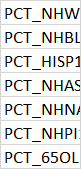
- Explore resturants, access, assistance
- Continue exploring insecurity
- Heatmap of food insecurity

## Importing the Data

In [5]:
supp_county = pd.read_csv('../data/processed/supp_county.csv')

supp_county.head(5)

,FIPS,State,County,2010 Census Population,"Population Estimate, 2011","Population Estimate, 2012","Population Estimate, 2013","Population Estimate, 2014","Population Estimate, 2015","Population Estimate, 2016"
0,1001.0,Alabama,Autauga,"54,571","55,255","55,027","54,792","54,977","55,035","55,416"
1,1003.0,Alabama,Baldwin,"182,265","186,653","190,403","195,147","199,745","203,690","208,563"
2,1005.0,Alabama,Barbour,"27,457","27,326","27,132","26,938","26,763","26,270","25,965"
3,1007.0,Alabama,Bibb,"22,915","22,736","22,645","22,501","22,511","22,561","22,643"
4,1009.0,Alabama,Blount,"57,322","57,707","57,772","57,746","57,621","57,676","57,704"


Questions:

- What does the population of the nation look like?
- Is food insecurity changing?
- Are subfactors of insecurity correlated?
- Does higher milk/soda ratio correlate pct obsese adult?
- Does higher soda taxes lower pct obsese adult?

### supp_county

A closer look at the most recent (2016) estimated population data for each county plotted against the 2010 census data. Most of the counties have fall along a line, which looks approximately like a slope of 1, meaning that the population change was minimal. Points outside of this pseudo-regression are counties whose population changed over the 6 year span. Points above the line are counties where population increased and points below the line are a decrease in population.   

([], <a list of 0 Text yticklabel objects>)

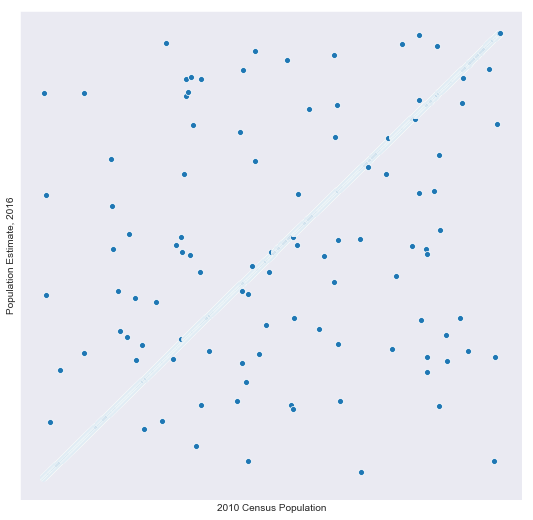

In [4]:
sns.scatterplot(x = '2010 Census Population', 
                y = 'Population Estimate, 2016',
                data = supp_county)

plt.xticks([])
plt.yticks([])

### supp_state

In [3]:
supp_state = pd.read_csv('../data/processed/supp_state.csv')
supp_state = supp_state.dropna(0)

In [4]:
def str_to_int(start_col, end_col):
    """Converts column to int in place.
    
    Args:
        start_col(int): the first column to convert
        end_col(int): the last column to convert
    """
    for i in range(start_col, end_col):
        supp_state.iloc[:, i] = supp_state.iloc[:, i].str.replace(',', '')
        supp_state.iloc[:, i] = pd.to_numeric(supp_state.iloc[:, i])
        
str_to_int(2, len(supp_state.columns))

In [5]:
supp_state['baseline'] = 0
supp_state['pop10_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2010']
supp_state['pop11_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2011']
supp_state['pop12_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2012']
supp_state['pop13_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2013']
supp_state['pop14_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2014']
supp_state['pop15_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2015']
supp_state['pop16_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2016']

pop_change = supp_state[['StateFIPS',
                         'State',
                         'baseline',
                         'pop10_change',
                         'pop11_change',
                         'pop12_change',
                         'pop13_change',
                         'pop14_change',
                         'pop15_change',
                         'pop16_change']]

pop_change = pop_change.rename(index=str, columns={'baseline': '2009',
                                            'pop10_change': '2010',
                                            'pop11_change': '2011',
                                            'pop12_change': '2012',
                                            'pop13_change': '2013',
                                            'pop14_change': '2014',
                                            'pop15_change': '2015',
                                            'pop16_change': '2016'})

pop_change = pd.melt(pop_change, 
               id_vars=['State'], 
               value_vars=['2009', '2010', '2011', '2012',
                           '2013', '2014', '2015', '2016'])

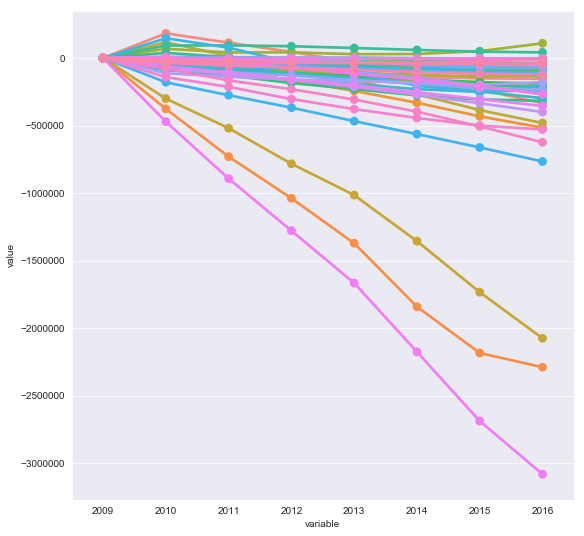

In [11]:
pop_plot = sns.pointplot(x = 'variable', y = 'value', hue = 'State', data = pop_change)

pop_plot.legend_.remove()

plt.show()

### insecurity

In [3]:
insecurity = pd.read_csv('../data/processed/insecurity.csv')

insecurity.tail(2)

,FIPS,State,County,FOODINSEC_10_12,FOODINSEC_13_15,CH_FOODINSEC_12_15,VLFOODSEC_10_12,VLFOODSEC_13_15,CH_VLFOODSEC_12_15,FOODINSEC_CHILD_01_07,FOODINSEC_CHILD_03_11
3141,56043,WY,Washakie,13.8,13.2,-0.6,5.1,5.3,0.2,9.0,7.9
3142,56045,WY,Weston,13.8,13.2,-0.6,5.1,5.3,0.2,9.0,7.9


paired t-test
why: the observations are not independent, should be highly dependent. However, since we're comparing them over time and looking at the same counties.
anova for foodinsec

for report:
Looking at the density plots for food insecurity over a 3 year span, going from 10-12 to 13-15 the variance seems to shrink while the mean stays the same. This is [XYZ] by our ANOVA

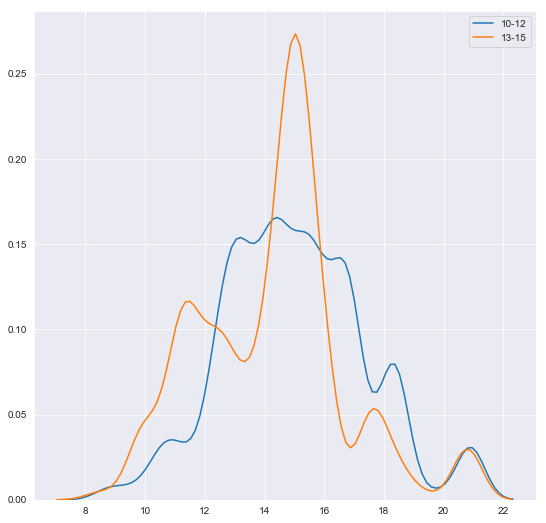

In [28]:
sns.kdeplot(insecurity['FOODINSEC_10_12'], label='10-12')
sns.kdeplot(insecurity['FOODINSEC_13_15'], label='13-15')
plt.legend()

This messy looking code reduces the dataframe to 1 observation per state and returns only the states that have had a increase in food insecurity from 2010 to 2015. 17 states including the District of Columbia saw a increase in food insecurity, 2 states saw no change and 31 states had a decrease in food insecurity.

In [40]:
insecurity.groupby(['State']).head(1)[insecurity['CH_FOODINSEC_12_15'] > 0]

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,FIPS,State,County,FOODINSEC_10_12,FOODINSEC_13_15,CH_FOODINSEC_12_15,VLFOODSEC_10_12,VLFOODSEC_13_15,CH_VLFOODSEC_12_15,FOODINSEC_CHILD_01_07,FOODINSEC_CHILD_03_11
67,2013,AK,Aleutians East,12.1,13.3,1.2,4.4,4.4,0.0,7.4,8.0
316,10001,DE,Kent,12.0,13.2,1.2,4.5,4.8,0.3,6.3,7.0
319,11001,DC,District of Columbia,11.6,11.9,0.3,4.9,3.2,-1.7,9.0,11.2
789,19001,IA,Adair,13.5,14.8,1.3,6.3,6.1,-0.2,7.5,8.3
888,20001,KS,Allen,14.4,14.6,0.2,5.5,5.5,0.0,8.8,9.3
993,21001,KY,Adair,15.6,17.6,2.0,6.2,7.3,1.1,8.0,10.0
1113,22001,LA,Acadia,15.7,18.4,2.7,4.8,7.7,2.9,9.1,9.0
1217,25001,MA,Barnstable,14.9,15.8,0.9,7.1,7.4,0.3,6.4,7.1
1231,26001,MI,Alcona,13.4,14.9,1.5,5.3,6.4,1.1,7.6,8.0
1764,33001,NH,Belknap,13.4,14.8,1.4,5.0,5.6,0.6,4.8,5.1


([], <a list of 0 Text xticklabel objects>)

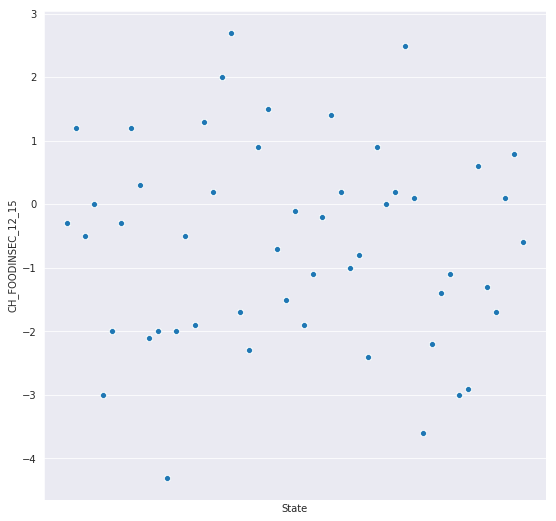

In [15]:
sns.scatterplot(x='State', y='CH_FOODINSEC_12_15', data=insecurity)
plt.xticks([])

A correlation plot of the insecurity data. We have essential 3 variables: food insecurity, very low food insecurity and child food insecurity. I'd expect food insecurity to be highly correlated very low food security and child food insecurity. FIPS should have no correlation with any variable, I don't think that there is a correlation with alphabetical order and food insecurity.

As expected FIPS seems to be uncorrelated with all the other variables. also unsuprisingly we see that the same variables taken at different times are the most highly correlated. All correlations are either positive or uncorrelated. Food insecurity has a stronger positive correlation with very low security than it does with child food security.

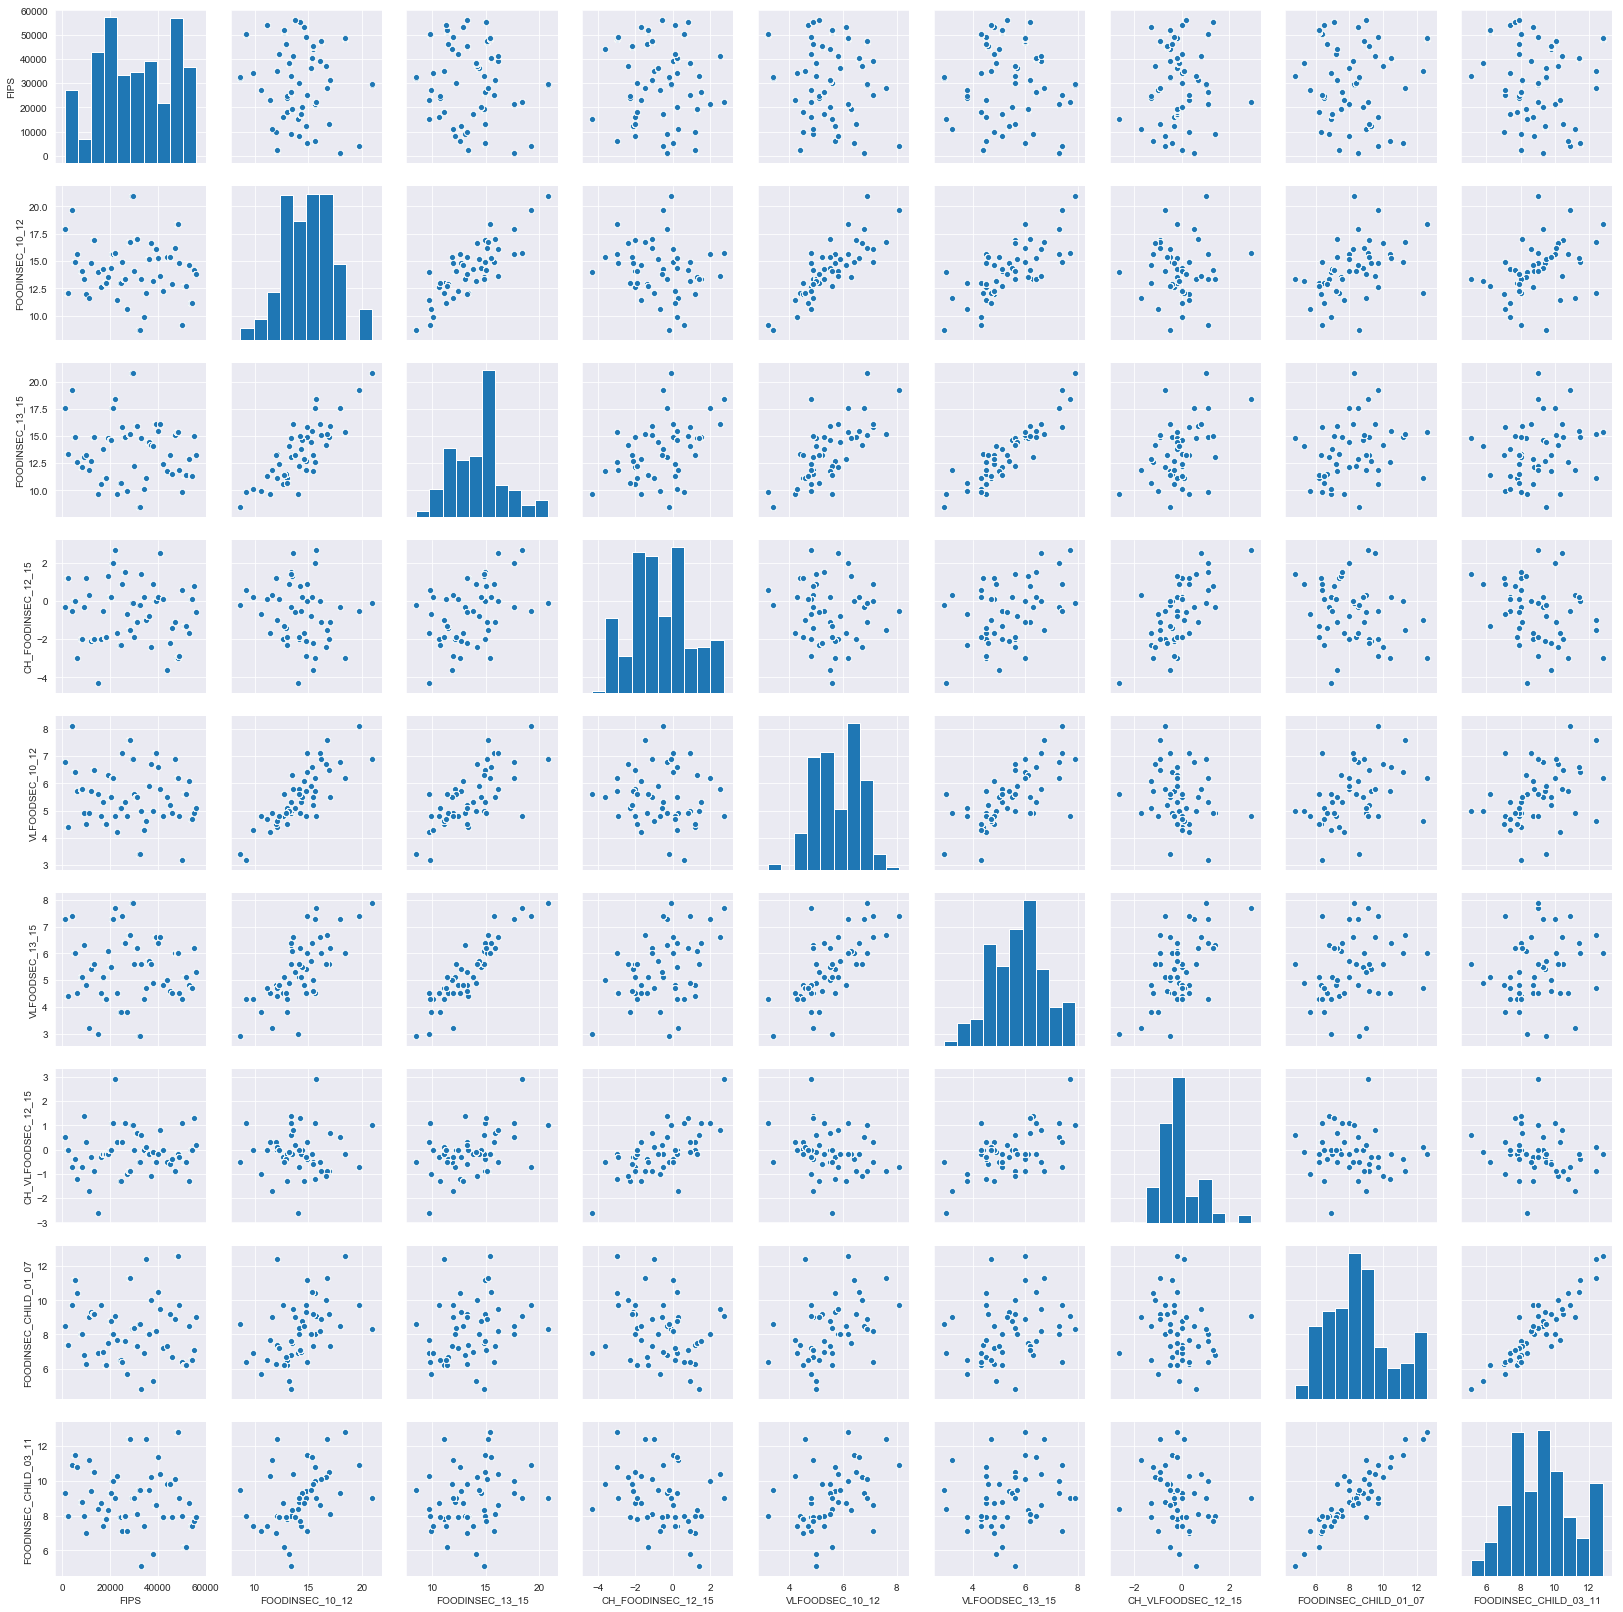

In [34]:
sns.pairplot(insecurity)

In [5]:
taxes = pd.read_csv('../data/processed/price_taxes.csv')

taxes.head(20)

,FIPS,State,County,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,SODATAX_STORES14,SODATAX_VENDM14,CHIPSTAX_STORES14,CHIPSTAX_VENDM14,FOOD_TAX14
0,1001,AL,Autauga,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
1,1003,AL,Baldwin,1.017690,1.001391,0.940165,4.0,4.0,4.0,4.0,4.0
2,1005,AL,Barbour,1.136671,0.992584,1.059400,4.0,4.0,4.0,4.0,4.0
3,1007,AL,Bibb,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
4,1009,AL,Blount,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
5,1011,AL,Bullock,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
6,1013,AL,Butler,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
7,1015,AL,Calhoun,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
8,1017,AL,Chambers,0.856725,0.990880,0.799857,4.0,4.0,4.0,4.0,4.0
9,1019,AL,Cherokee,0.856725,0.990880,0.799857,4.0,4.0,4.0,4.0,4.0


Question:

Does higher milk/soda ratio correlate pct obsese adult?

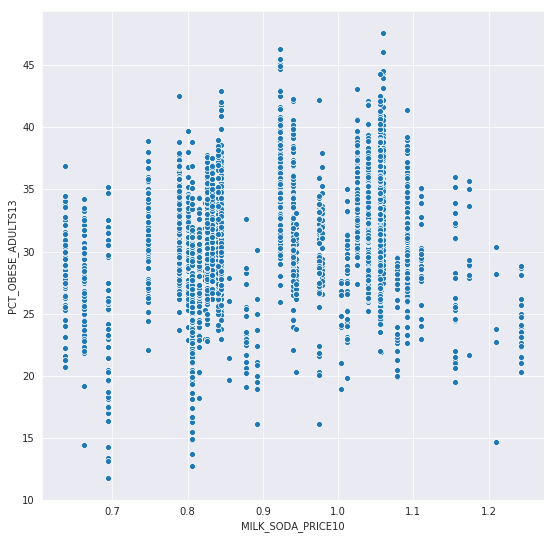

In [9]:
sns.scatterplot(x=taxes['MILK_SODA_PRICE10'], y=health['PCT_OBESE_ADULTS13'])

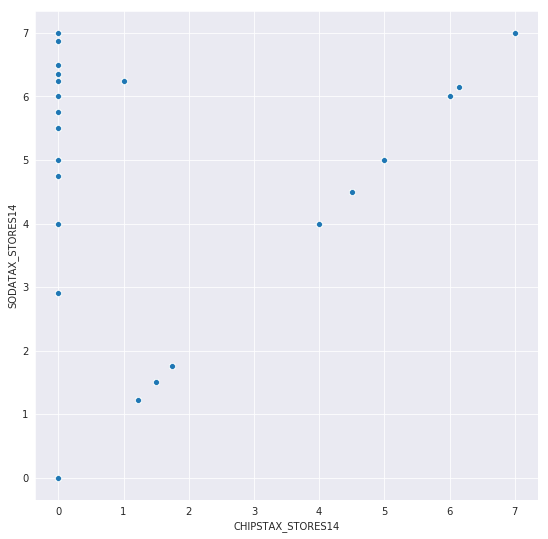

In [4]:
sns.scatterplot(x='CHIPSTAX_STORES14', y='SODATAX_STORES14', data=taxes)

In [6]:
health = pd.read_csv('../data/processed/health.csv')

health.head(1)

,FIPS,State,County,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13,PCT_HSPA15,RECFAC09,RECFAC14,PCH_RECFAC_09_14,RECFACPTH09,RECFACPTH14,PCH_RECFACPTH_09_14
0,1001,AL,Autauga,11.4,13.0,31.5,34.1,25.4,4,5,25.0,0.073889,0.090261,22.156783


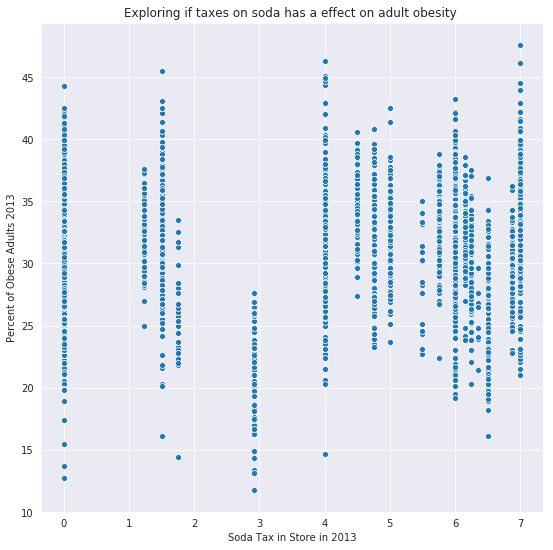

In [25]:
soda_store14_obese13 = sns.scatterplot(x=taxes['SODATAX_STORES14'], y=health['PCT_OBESE_ADULTS13'])

soda_store14_obese13.set(xlabel='Soda Tax in Store in 2013', ylabel='Percent of Obese Adults 2013', 
                         title='Exploring if taxes on soda has a effect on adult obesity ')

Question:

Does higher soda taxes lower pct obsese adult?

In [11]:
stores = pd.read_csv('../data/processed/stores.csv')

Stacked barplot of store types

In [ ]:
sns.boxplot()

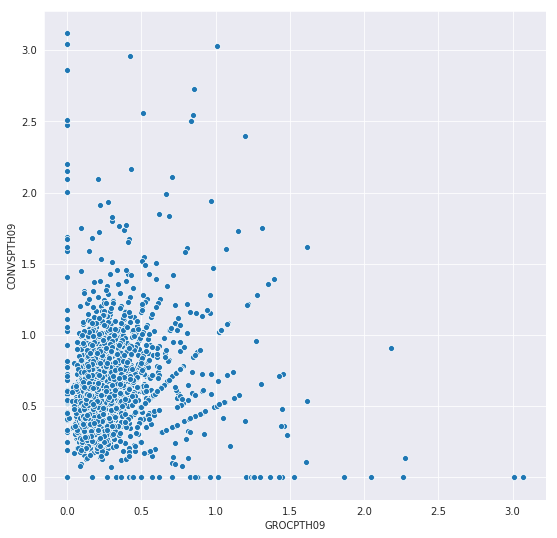

In [28]:
sns.scatterplot(x='GROCPTH09', y='CONVSPTH09', data=stores)

Do higher amounts of grocery stores mean lower amounts of convience stores?

Take pct of all stores for each, compare means